In [7]:
import sys
import os
import time
import einops
import pickle
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from official.nlp import optimization
import matplotlib.pyplot as plt

In [8]:
# Class for loading image and text data

class ITM_DataLoader:
    BATCH_SIZE = 16
    IMAGE_SIZE = (224, 224)
    IMAGE_SHAPE = (224, 224, 3)
    SENTENCE_EMBEDDING_SHAPE = 384
    AUTOTUNE = tf.data.AUTOTUNE
    DATA_PATH = "D:\_GITHUB_\Image-Text-Matching\data"
    IMAGES_PATH = DATA_PATH + "/images"
    train_data_file = DATA_PATH + "/flickr8k.TrainImages.txt"
    dev_data_file = DATA_PATH + "/flickr8k.DevImages.txt"
    test_data_file = DATA_PATH + "/flickr8k.TestImages.txt"
    sentence_embeddings_file = DATA_PATH + "/flickr8k.cmp9137.sentence_transformers.pkl"
    sentence_embeddings = {}
    train_ds = None
    val_ds = None
    test_ds = None

    def __init__(self):
        self.sentence_embeddings = self.load_sentence_embeddings()
        self.train_ds = self.load_classifier_data(self.train_data_file)
        self.val_ds = self.load_classifier_data(self.dev_data_file)
        self.test_ds = self.load_classifier_data(self.test_data_file)
        print("done loading data...")

    # Sentence embeddings are dense vectors representing text data, one vector per sentence.
    # Sentences with similar vectors would mean sentences with equivalent meanning.
    # They are useful here to provide text-based features of questions in the data.
    # Note: sentence embeddings don't include label info, they are solely based on captions.
    def load_sentence_embeddings(self):
        sentence_embeddings = {}
        print("READING sentence embeddings...")
        with open(self.sentence_embeddings_file, "rb") as f:
            data = pickle.load(f)
            for sentence, dense_vector in data.items():
                # print("*sentence=",sentence)
                sentence_embeddings[sentence] = dense_vector
        print("Done reading sentence_embeddings!")
        return sentence_embeddings

    # In contrast to text-data based on pre-trained features, image data does not use
    # any form of pre-training in this program. Instead, it makes use of raw pixels.
    # Notes that input features to the classifier are only pixels and sentence embeddings.
    def process_input(self, img_path, dense_vector, text, label):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.IMAGE_SIZE)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.cast(img, tf.float32) / 255
        features = {}
        features["image_input"] = img
        features["text_embedding"] = dense_vector
        features["caption"] = text
        features["file_name"] = img_path
        return features, label

    # This method loads the multimodal data, which comes from the following sources:
    # (1) image files in IMAGES_PATH, and (2) files with pattern flickr8k.*Images.txt
    # The data is stored in a tensorflow data structure to make it easy to use by
    # the tensorflow model during training, validation and test. This method was
    # carefully prepared to load the data rapidly, i.e., by loading already created
    # sentence embeddings (text features) rather than creating them at runtime.
    def load_classifier_data(self, data_files):
        print("LOADING data from " + str(data_files))
        print("=========================================")
        image_data = []
        text_data = []
        embeddings_data = []
        label_data = []

        # get image, text, label of image_files
        with open(data_files) as f:
            lines = f.readlines()
            for line in lines:
                line = line.rstrip("\n")
                img_name, text, raw_label = line.split("	")
                img_name = os.path.join(self.IMAGES_PATH, img_name.strip())

                # get binary labels from match/no-match answers
                label = [1, 0] if raw_label == "match" else [0, 1]
                # print("I=%s T=%s _L=%s L=%s" % (img_name, text, raw_label, label))

                # get sentence embeddings (of textual captions)
                text_sentence_embedding = self.sentence_embeddings[text]
                text_sentence_embedding = tf.constant(text_sentence_embedding)

                image_data.append(img_name)
                embeddings_data.append(text_sentence_embedding)
                text_data.append(text)
                label_data.append(label)

        print("|image_data|=" + str(len(image_data)))
        print("|text_data|=" + str(len(text_data)))
        print("|label_data|=" + str(len(label_data)))

        # prepare a tensorflow dataset using the lists generated above
        dataset = tf.data.Dataset.from_tensor_slices(
            (image_data, embeddings_data, text_data, label_data)
        )
        dataset = dataset.shuffle(self.BATCH_SIZE * 8)
        dataset = dataset.map(self.process_input, num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.batch(self.BATCH_SIZE).prefetch(self.AUTOTUNE)
        self.print_data_samples(dataset)
        return dataset

    def print_data_samples(self, dataset):
        print("PRINTING data samples...")
        print("-----------------------------------------")
        for features_batch, label_batch in dataset.take(1):
            for i in range(1):
                print(f'Image pixels: {features_batch["image_input"]}')
                print(f'Sentence embeddings: {features_batch["text_embedding"]}')
                print(f'Caption: {features_batch["caption"].numpy()}')
                label = label_batch.numpy()[i]
                print(f"Label : {label}")
        print("-----------------------------------------")

In [9]:
# Main class for the Image-Text Matching (ITM) task

class ITM_Classifier(ITM_DataLoader):
    epochs = 20
    learning_rate = 3e-5
    class_names = {"match", "no-match"}
    num_classes = len(class_names)
    classifier_model = None
    history = None
    classifier_model_name = "ITM_Classifier-flickr"

    def __init__(self):
        super().__init__()
        self.build_classifier_model()
        self.train_classifier_model()
        self.test_classifier_model()

    # return learnt feature representations of input data (images)
    def create_vision_encoder(
        self, num_projection_layers, projection_dims, dropout_rate
    ):
        img_input = layers.Input(shape=self.IMAGE_SHAPE, name="image_input")

        # Use InceptionV3 with ImageNet weights, excluding the top (fully connected) layer
        base_model = InceptionV3(
            include_top=False,
            weights="imagenet",
            input_tensor=img_input,
            input_shape=self.IMAGE_SHAPE,
        )
        # Avoid training the base model to retain learned features
        base_model.trainable = False

        # Continue from where the base model leaves off
        cnn_layer = base_model.output
        cnn_layer = layers.GlobalAveragePooling2D()(
            cnn_layer
        )  # Added to reduce dimensions
        cnn_layer = layers.Dropout(dropout_rate)(cnn_layer)

        outputs = self.project_embeddings(
            cnn_layer, num_projection_layers, projection_dims, dropout_rate
        )
        return img_input, outputs

    # return learnt feature representations based on dense layers, dropout, and layer normalisation
    def project_embeddings(
        self, embeddings, num_projection_layers, projection_dims, dropout_rate
    ):
        projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
        for _ in range(num_projection_layers):
            x = tf.nn.gelu(projected_embeddings)
            x = layers.Dense(projection_dims)(x)
            x = layers.Dropout(dropout_rate)(x)
            x = layers.Add()([projected_embeddings, x])
            projected_embeddings = layers.LayerNormalization()(x)
        return projected_embeddings

    # return learnt feature representations of input data (text embeddings in the form of dense vectors)
    def create_text_encoder(self, num_projection_layers, projection_dims, dropout_rate):
        text_input = keras.Input(
            shape=self.SENTENCE_EMBEDDING_SHAPE, name="text_embedding"
        )
        outputs = self.project_embeddings(
            text_input, num_projection_layers, projection_dims, dropout_rate
        )
        return text_input, outputs

    # put together the feature representations above to create the image-text (multimodal) deep learning model
    def build_classifier_model(self):
        print(f"BUILDING model")
        img_input, vision_net = self.create_vision_encoder(
            num_projection_layers=1, projection_dims=128, dropout_rate=0.1
        )
        text_input, text_net = self.create_text_encoder(
            num_projection_layers=1, projection_dims=128, dropout_rate=0.1
        )
        net = tf.keras.layers.Concatenate(axis=1)([vision_net, text_net])
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(
            self.num_classes, activation="softmax", name=self.classifier_model_name
        )(net)
        self.classifier_model = tf.keras.Model(
            inputs=[img_input, text_input], outputs=net
        )
        self.classifier_model.summary()

    def train_classifier_model(self):
        print(f"TRAINING model")
        steps_per_epoch = tf.data.experimental.cardinality(self.train_ds).numpy()
        num_train_steps = steps_per_epoch * self.epochs
        num_warmup_steps = int(0.2 * num_train_steps)

        loss = tf.keras.losses.KLDivergence()
        metrics = tf.keras.metrics.BinaryAccuracy()
        optimizer = optimization.create_optimizer(
            init_lr=self.learning_rate,
            num_train_steps=num_train_steps,
            num_warmup_steps=num_warmup_steps,
            optimizer_type="adamw",
        )

        self.classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        # uncomment the next line if you wish to make use of early stopping during training
        # callbacks = [tf.keras.callbacks.EarlyStopping(patience=11, restore_best_weights=True)]

        self.history = self.classifier_model.fit(
            x=self.train_ds, validation_data=self.val_ds, epochs=self.epochs
        )  # , callbacks=callbacks)
        print("model trained!")

    def test_classifier_model(self):
        print(
            "TESTING classifier model (showing a sample of image-text-matching predictions)..."
        )
        num_classifications = 0
        num_correct_predictions = 0

        # read test data for ITM classification
        for features, groundtruth in self.test_ds:
            groundtruth = groundtruth.numpy()
            predictions = self.classifier_model(features)
            predictions = predictions.numpy()
            captions = features["caption"].numpy()
            file_names = features["file_name"].numpy()

            # read test data per batch
            for batch_index in range(0, len(groundtruth)):
                predicted_values = predictions[batch_index]
                probability_match = predicted_values[0]
                probability_nomatch = predicted_values[1]
                predicted_class = (
                    "[1 0]" if probability_match > probability_nomatch else "[0 1]"
                )
                if str(groundtruth[batch_index]) == predicted_class:
                    num_correct_predictions += 1
                num_classifications += 1

                # print a sample of predictions -- about 10% of all possible
                if random.random() < 0.1:
                    caption = captions[batch_index]
                    file_name = file_names[batch_index].decode("utf-8")
                    print(
                        "ITM=%s PREDICTIONS: match=%s, no-match=%s \t -> \t %s"
                        % (caption, probability_match, probability_nomatch, file_name)
                    )

        # reveal test performance using our own calculations above
        accuracy = num_correct_predictions / num_classifications
        print("TEST accuracy=%4f" % (accuracy))

        # reveal test performance using Tensorflow calculations
        loss, accuracy = self.classifier_model.evaluate(self.test_ds)
        print(f"Tensorflow test method: Loss: {loss}; ACCURACY: {accuracy}")

In [10]:
# Let's create an instance of the main class
itm = ITM_Classifier()

READING sentence embeddings...
Done reading sentence_embeddings!
LOADING data from D:\_GITHUB_\Image-Text-Matching\data/flickr8k.TrainImages.txt
|image_data|=19386
|text_data|=19386
|label_data|=19386
PRINTING data samples...
-----------------------------------------
Image pixels: [[[[0.39607844 0.40392157 0.4509804 ]
   [0.39607844 0.40392157 0.4509804 ]
   [0.41568628 0.42745098 0.4627451 ]
   ...
   [0.15294118 0.18039216 0.11764706]
   [0.1254902  0.13333334 0.08235294]
   [0.10588235 0.11372549 0.07058824]]

  [[0.41568628 0.42352942 0.47058824]
   [0.4        0.4117647  0.44705883]
   [0.41568628 0.42745098 0.4627451 ]
   ...
   [0.14509805 0.17254902 0.10980392]
   [0.16078432 0.1764706  0.12156863]
   [0.12941177 0.13725491 0.09411765]]

  [[0.42352942 0.43529412 0.47058824]
   [0.40392157 0.41568628 0.44313726]
   [0.43137255 0.43137255 0.4627451 ]
   ...
   [0.13333334 0.16078432 0.09803922]
   [0.12941177 0.14509805 0.09019608]
   [0.11764706 0.12941177 0.08627451]]

  ...



In [11]:
def plot_training_history(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

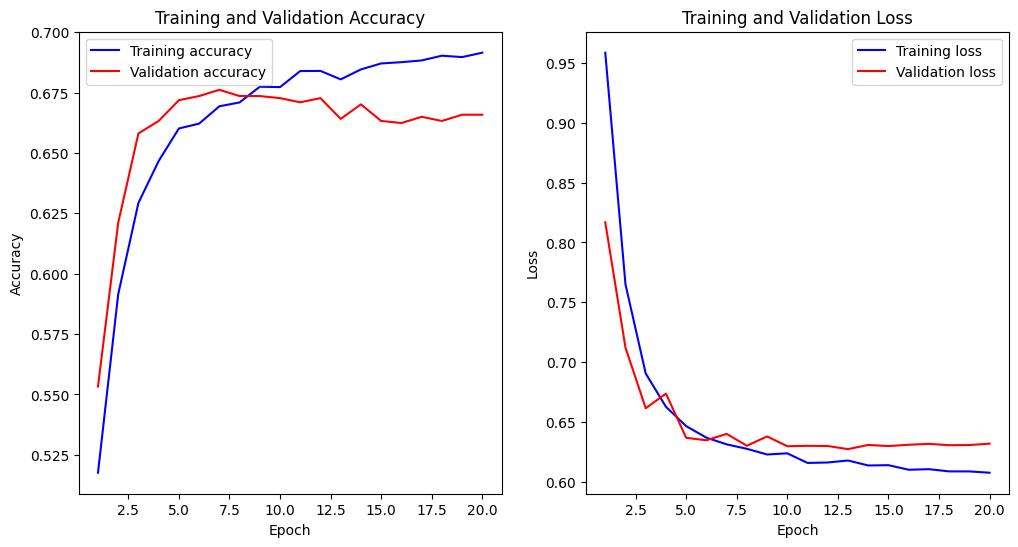

In [12]:
plot_training_history(itm.history)